In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import time

import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import numpy.linalg as linalg

from scipy import interpolate
from optimize.snopt7 import SNOPT_solver

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:

# 
# Attempt to solve for the positions of a randomly scattered set of UWB units
#

# Number of units
n = 100
dim = 3
known = 3

#
# Create a random 3D pointset
#
points_truth = np.matrix(np.random.randn(n, dim) * 10)
print "Points: ", points_truth.shape
print points_truth

#
# Calculate the pairwise distances
#
pairwise_dist_truth = sp.spatial.distance.pdist(points_truth)
print "Pairwise distances:", pairwise_dist_truth.shape
print pairwise_dist_truth

Points:  (100, 3)
[[  8.02331054  14.05623654  18.28300088]
 [-13.14549721   5.14466935 -11.31906158]
 [ -8.3278964    0.6543468   -0.05997051]
 [ 14.56033758  -0.4807096  -18.05490302]
 [  3.78764549  -8.21229011   2.93862027]
 [ 12.67274499  22.46319813  -2.33706228]
 [  8.39929016  -4.85762528  -4.3785068 ]
 [-32.02951319   2.44489566   8.2245419 ]
 [ -3.7316159   -0.78791349 -15.36357682]
 [-10.75555646  12.07914429 -14.75639847]
 [ -5.12169042  -8.87283657  -1.66826107]
 [  4.03841382  -7.93303375  -2.76157556]
 [ -0.23430734 -14.30031109   9.50656378]
 [ 25.42072108   8.46860547   7.39039894]
 [ 10.27800948  13.83846551  18.97975949]
 [ -7.51660059   3.66292204  17.48309775]
 [ 15.41226908  -6.21661115  -5.053523  ]
 [  8.78902147   2.27242696  -0.53664089]
 [ -5.86122149  22.33890491   7.89623329]
 [-13.78394411   6.85631575  -8.74468963]
 [  6.17221325   6.85390974  -8.01025501]
 [  7.58100629  -7.87523055   5.40631034]
 [-12.01401299  -0.63549821   3.86588414]
 [ 13.13874132 -

In [131]:
#
# Set up optimization problem to solve for positions
#
snopt = SNOPT_solver()
snopt.setOption('Verbose',True)
snopt.setOption('Solution print',False)
snopt.setOption('Print file','uwb1.out')
snopt.setOption('Iteration limit',8000)
snopt.setOption('Print level',3)
snopt.setOption('Major optimality',2e-12)

inf = 1.0e20

x = np.zeros((n, dim))
x = np.matrix(x)
x0 = x.A1

xlow = np.matrix(-inf + np.zeros((n, dim)))
xupp = np.matrix( inf + np.zeros((n, dim)))

#
# I have some known positions
#
for i in range(known):
    xlow[i,:] = points_truth[i,:]
    xupp[i,:] = points_truth[i,:]

low_F = np.array([-inf])
upp_F = np.array([ inf])

def objF(status,x,needF,needG,cu,iu,ru):
    points_estimated = x.reshape((n, dim))
    pairwise_dist_estimated = sp.spatial.distance.pdist(points_estimated)

    return status, [np.sum( (pairwise_dist_estimated - pairwise_dist_truth)**2 )]

a = time.time()
snopt.snopta(name="UWB_1",usrfun=objF,x0=x0,xlow=xlow.A1,xupp=xupp.A1,
             Flow=low_F,Fupp=upp_F,ObjRow=1)
b = time.time()

print "Solved in %.4fs" % (b - a)

print "Value of objective function: %.8f" % snopt.F[0]

 --> Linear component of Jacobian not provided
 --> Nonlinear component of Jacobian not provided
  Could not determine Jacobian structure from user input
  Calling snJac...
 --> Initial xstate not provided; setting to 0
 --> Initial Fstate not provided; setting to 0
----------------------------------------------------------------------------------
 SNOPT python interface   (Feb 2015)
   Problem: UWB_1
   # variables = 300; # constraints = 1 

     Name state(j)      low(j)           x(j)           upp(j)        mul(j)
x:
        0       0    8.023311e+00    0.000000e+00    8.023311e+00    0.000000e+00
        1       0    1.405624e+01    0.000000e+00    1.405624e+01    0.000000e+00
        2       0    1.828300e+01    0.000000e+00    1.828300e+01    0.000000e+00
        3       0   -1.314550e+01    0.000000e+00   -1.314550e+01    0.000000e+00
        4       0    5.144669e+00    0.000000e+00    5.144669e+00    0.000000e+00
        5       0   -1.131906e+01    0.000000e+00   -1.131906e+

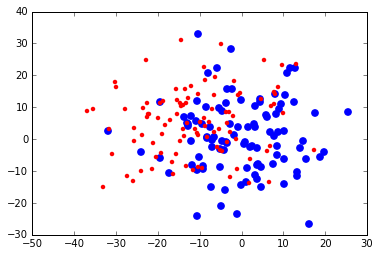

In [132]:
#
# Check the error between solved-for and actual pointset
#
points_estimated = snopt.x.reshape((n, dim))

plt.scatter(points_truth[:,0],points_truth[:,1], c="blue", alpha=1, s=60, linewidth=0)
plt.scatter(points_estimated[:,0],points_estimated[:,1], c="red", alpha=1, linewidth=0)